In [10]:
import dkist
import astropy
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
from ndcube import NDCube
from sun_blinker import SunBlinker
import astropy.units as u
from sunkit_image import coalignment
import cv2

In [3]:
vbi_gband_dir = '../../src/DKIST/vbi_1024/AEZDV/'
vbi_gband_dataset = dkist.load_dataset(vbi_gband_dir)

In [4]:
vbi_gband_dataset.meta['headers'][0]['DATE-AVG']

'2022-10-24T18:59:10.640349'

<WCSAxes: >

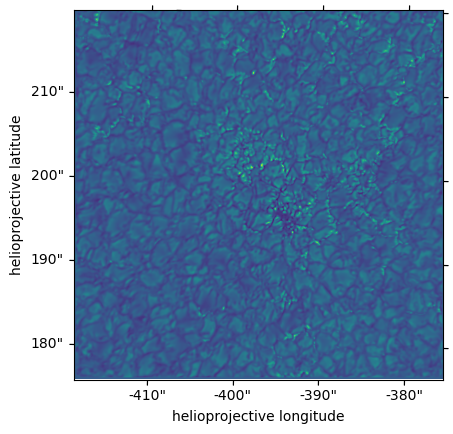

In [5]:
vbi_gband_dataset[0].plot()

In [6]:
vbi_gband_map = sunpy.map.Map('../../src/DKIST/vbi_1024/AEZDV/VBI_2022_10_24T18_59_10_640_00430500_I_AEZDV_L1.fits')
vbi_gband_map.meta['rsun_ref'] = 696000000.0

vbi_gband_map = sunpy.map.Map(vbi_gband_map.data[256:-256, 256:-256], vbi_gband_map.wcs[256:-256, 256:-256])
vbi_gband_map = vbi_gband_map.resample([vbi_gband_map.data.shape[1]//4, vbi_gband_map.data.shape[0]//4,]*u.pix)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


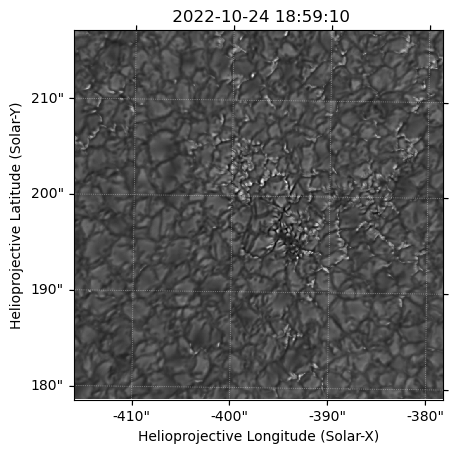

In [7]:
vbi_gband_map.plot()

In [22]:
hmi_ic_map = sunpy.map.Map('../../src/HMI/20221024/lvl15/hmi.Ic_45s.20221024_190000_TAI.2.continuum.fits')

In [23]:
hmi_ic_map.date

<Time object: scale='utc' format='isot' value=2022-10-24T18:58:57.700>

In [24]:
vbi_gband_map_downsampled = vbi_gband_map.resample(vbi_gband_map.data.shape*u.pix/\
                                                   ((hmi_ic_map.scale.axis1/vbi_gband_map.scale.axis1.to_value(u.arcsec/u.pix)).value)*4)

In [25]:
with propagate_with_solar_surface(rotation_model='rigid'):
    hmi_ic_map_repro = hmi_ic_map.reproject_to(vbi_gband_map_downsampled.wcs)

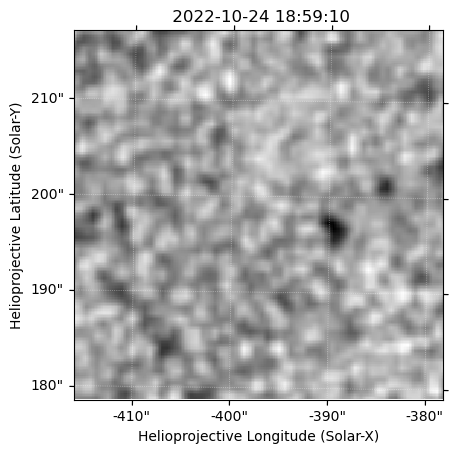

In [26]:
hmi_ic_map_repro.plot()

In [27]:
vbi_gband_map_downsampled.data.shape

(243, 243)

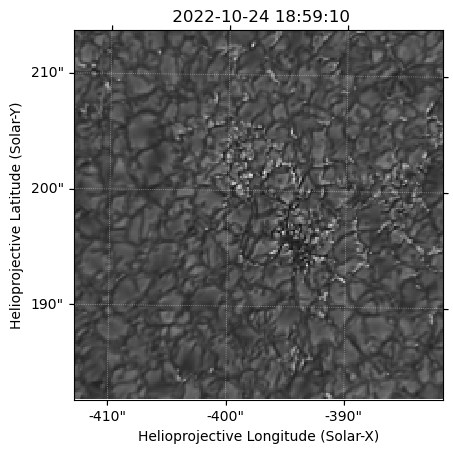

In [28]:
vbi_gband_map_crop = vbi_gband_map_downsampled.submap([20,20]*u.pix, 
                                          top_right=[220,220]*u.pix)
vbi_gband_map_crop.plot()

In [29]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift
    

In [30]:
vbi_hmi_xshift, vbi_hmi_yshift = coalign_shift(hmi_ic_map_repro, vbi_gband_map_crop)

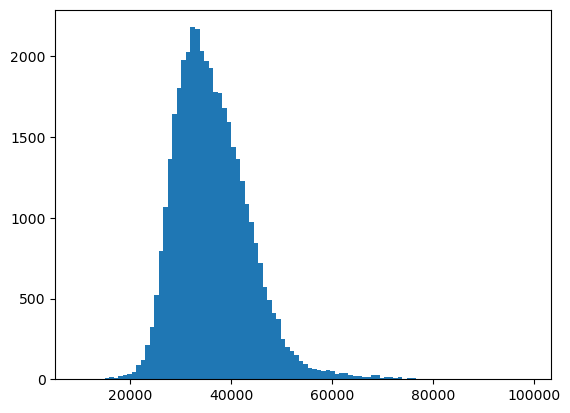

In [31]:
_ = plt.hist(vbi_gband_map_crop.data.flatten(), bins=100)

In [32]:
vbi_hmi_xshift, vbi_hmi_yshift

(<Angle 3.40633854 arcsec>, <Angle 1.46354454 arcsec>)

In [33]:
vbi_gband_map_shifted = vbi_gband_map.shift_reference_coord(vbi_hmi_xshift, vbi_hmi_yshift)

In [35]:
with propagate_with_solar_surface(rotation_model='rigid'):
    SunBlinker(vbi_gband_map_shifted, hmi_ic_map, reproject=True, fps=1)

In [36]:
vbi_hmi_xshift_manual, vbi_hmi_yshift_manual = vbi_hmi_xshift + 1*u.arcsec, vbi_hmi_yshift + 0*u.arcsec
vbi_gband_map_shifted_manual = vbi_gband_map.shift_reference_coord(vbi_hmi_xshift_manual, vbi_hmi_yshift_manual)
SunBlinker(vbi_gband_map_shifted_manual, hmi_ic_map, reproject=True, fps=1)

In [56]:
vbi_hbeta_map = sunpy.map.Map('../../src/DKIST/vbi_1024/BJOLO/VBI_2022_10_24T19_20_05_866_00486136_I_BJOLO_L1.fits')
vbi_hbeta_map.meta['rsun_ref'] = 696000000.0

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


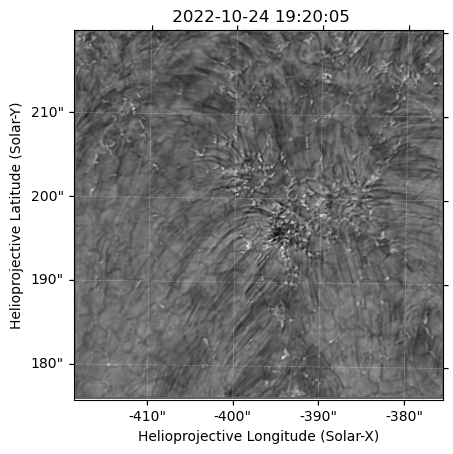

In [ ]:
vbi_hbeta_map.plot()

In [ ]:
SunBlinker(vbi_hbeta_map, vbi_gband_map, reproject=False)